# NoPainNoTrain HW2
In this folder you can find model.ipynb containing the actual submission and the folder preprocessing with the notebooks. See README for descriptions.

## 🤩 Initialization


In [ ]:
# g drive connect
from google.colab import drive
drive.mount("/gdrive")
%cd /gdrive/My Drive/HW2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/HW2


In [ ]:
# Imports
import os
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Enable inline plotting in Jupyter Notebooks
%matplotlib inline


# TensorFlow Keras layers and model building
from tensorflow.keras.layers import Layer, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeNormal

In [ ]:
# random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Assuming `training_val_test_set` is loaded and `seed` is defined
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
data = np.load("cleaned_dataset.npz")
training_val_test_set = data["training_set"]  # training + validation set
X_test_kaggle = data["test_set"]  # Kaggle test set

# Split training_val_test_set into train+val and test without separating X and y
train_val_set, test_set = train_test_split(training_val_test_set, random_state=seed, test_size=0.1)

# Further split train_val_set into train and val
train_set, val_set = train_test_split(train_val_set, random_state=seed, test_size=0.1)

# Process each dataset
def process_dataset(dataset):
    # Split into images (X) and labels (y)
    X = np.array([sample[0] for sample in dataset])
    y = np.array([sample[1] for sample in dataset])
    # Normalize the images
    X = X[..., np.newaxis] / 255.0
    return X, y

# Process each set
X_train, y_train = process_dataset(train_set)
X_val, y_val = process_dataset(val_set)
X_test, y_test = process_dataset(test_set)
X_test_kaggle = X_test_kaggle[..., np.newaxis] / 255.0

# Compute problem parameters
input_shape = X_train.shape[1:]  # Assuming consistent shape
num_classes = len(np.unique(y_train))

# Print dataset shapes
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")


Training X shape: (2028, 64, 128, 1)
Training y shape: (2028, 64, 128)
Validation X shape: (226, 64, 128, 1)
Validation y shape: (226, 64, 128)
Test X shape: (251, 64, 128, 1)
Test y shape: (251, 64, 128)
Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
import numpy as np
import cv2

def poisson_blend(class_region, target_image, target_position):
    """
    Blends the extracted class region into the target image using Poisson blending.
    """
    # Ensure the input images are of type uint8
    class_region = class_region.astype(np.uint8)
    target_image = target_image.astype(np.uint8)

    # Convert grayscale images to 3 channels (needed for seamlessClone)
    class_region_color = cv2.cvtColor(class_region, cv2.COLOR_GRAY2BGR)
    target_image_color = cv2.cvtColor(target_image, cv2.COLOR_GRAY2BGR)

    # Create a binary mask for the class region
    mask = np.ones(class_region.shape[:2], dtype=np.uint8) * 255

    # Perform seamless cloning
    center = (target_position[0] + class_region.shape[1] // 2, target_position[1] + class_region.shape[0] // 2)
    blended_image = cv2.seamlessClone(class_region_color, target_image_color, mask, center, cv2.MIXED_CLONE)

    # Convert back to grayscale
    blended_image_gray = cv2.cvtColor(blended_image, cv2.COLOR_BGR2GRAY)

    return blended_image_gray


def blend_masks(source_mask, target_mask, class_id, target_position, class_region_shape):
    """
    Inserts the class_region's mask into the target_mask at the given target_position.
    Args:
        source_mask (np.array): The mask of the source image.
        target_mask (np.array): The mask of the target image.
        class_id (int): The class ID to blend.
        target_position (tuple): (x, y) position for blending the class region.
        class_region_shape (tuple): Shape of the class region (height, width).
    Returns:
        blended_mask (np.array): The target mask with the class region mask blended in.
    """
    # Copy the target mask
    blended_mask = target_mask.copy()

    # Compute the region in the target mask
    target_x, target_y = target_position
    h, w = class_region_shape

    # Insert the source mask's class region
    blended_mask[target_y:target_y + h, target_x:target_x + w] = np.where(
        source_mask[:h, :w] == class_id, class_id, blended_mask[target_y:target_y + h, target_x:target_x + w])

    return blended_mask

def blend_class_into_image(source_image, target_image, source_mask, target_mask, class_id, flag=False):
    """
    Extracts the region of a class from the source_image and source_mask and blends it into the target_image
    and target_mask.
    """

    # Ensure images and masks are 2D
    source_image = np.squeeze(source_image)
    target_image = np.squeeze(target_image)
    source_mask = np.squeeze(source_mask)
    target_mask = np.squeeze(target_mask)

    # Identify the underrepresented class region in the source mask
    underrepresented_coords = np.where(source_mask == class_id)

    # Skip if the class does not exist in the source mask
    if len(underrepresented_coords[0]) == 0:
        #print(f"Class {class_id} not found in source mask. Skipping...")
        return target_image, target_mask, flag

    # Extract the bounding box of the class region
    y_min, y_max = np.min(underrepresented_coords[0]), np.max(underrepresented_coords[0])
    x_min, x_max = np.min(underrepresented_coords[1]), np.max(underrepresented_coords[1])

    # Extract the class region
    class_region = source_image[y_min:y_max, x_min:x_max]
    class_region_mask = source_mask[y_min:y_max, x_min:x_max]

    # Check if the class_region is empty
    if class_region.size == 0 or class_region_mask.size == 0:
        #print("Extracted class region is empty. Skipping...")
        return target_image, target_mask, flag

    # Get the height and width of the region
    h, w = class_region.shape[:2]

    # Determine target region bounds
    max_x = target_image.shape[1] - w
    max_y = target_image.shape[0] - h

    if max_x <= 0 or max_y <= 0:
        #print("Class region too large to fit in target image. Skipping...")
        return target_image, target_mask, flag

    # Randomly choose a position in the target image
    target_x = np.random.randint(0, max_x)
    target_y = np.random.randint(0, max_y)
    target_position = (target_x, target_y)

    # Blend the class region into the target image
    augmented_image = poisson_blend(class_region, target_image, target_position)
    flag=True

    # Blend the class region mask into the target mask
    augmented_mask = blend_masks(class_region_mask, target_mask, class_id, target_position, class_region.shape)

    return augmented_image, augmented_mask, flag



def augment_dataset(images, masks, class_id, augmentations_per_image=25):
    """
    Augments a dataset of images and masks by blending underrepresented class regions into other images.
    """
    augmented_images = []
    augmented_masks = []

    # augment the dataset
    for i in range(len(images)):
        # Select a random target image and mask
        target_idx = np.random.randint(0, len(images))
        target_image = np.squeeze(images[target_idx])
        target_mask = np.squeeze(masks[target_idx])

        try:
            # Blend the source image and mask into the target
            augmented_image, augmented_mask, flag = blend_class_into_image(
                np.squeeze(images[i]), target_image,
                np.squeeze(masks[i]), target_mask,
                class_id
            )
            augmented_images.append(augmented_image)
            augmented_masks.append(augmented_mask)

        except Exception as e:
            #print(f"Error during augmentation: {e}")
            augmented_image, augmented_mask = images[i], masks[i]
            augmented_images.append(augmented_image)
            augmented_masks.append(augmented_mask)

    # focus on the class 4
    for i in range(len(images)):
        for _ in range(augmentations_per_image):
            # Select a random target image and mask
            target_idx = np.random.randint(0, len(images))
            target_image = np.squeeze(images[target_idx])
            target_mask = np.squeeze(masks[target_idx])

            try:
                # Blend the source image and mask into the target
                augmented_image, augmented_mask, flag = blend_class_into_image(
                    np.squeeze(images[i]), target_image,
                    np.squeeze(masks[i]), target_mask,
                    class_id
                )
                if (flag==True):
                  augmented_images.append(augmented_image)
                  augmented_masks.append(augmented_mask)

            except Exception as e:
                #print(f"Error during augmentation: {e}")
                pass

    return np.array(augmented_images), np.array(augmented_masks)

class_id_to_augment = 4
augmented_images, augmented_masks = augment_dataset(train_set[:,0], train_set[:,1], class_id=class_id_to_augment)

print(f"Augmented images shape: {augmented_images.shape}")
print(f"Augmented masks shape: {augmented_masks.shape}")
print(augmented_images.min())
print(augmented_images.max())
print(augmented_masks.min())
print(augmented_masks.max())

augmented_images_norm = augmented_images.astype(np.float32)/255.0

Augmented images shape: (3203, 64, 128)
Augmented masks shape: (3203, 64, 128)
0.0
255.0
0.0
4.0


In [ ]:
temp = np.stack((augmented_images, augmented_masks), axis=1)

In [ ]:
train_set = np.concatenate((train_set, temp), axis=0)

In [ ]:
X_train, y_train = process_dataset(train_set)

In [ ]:
# Class Weights computation
flattened_labels = y_train.flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(flattened_labels), y=flattened_labels)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

def create_sample_weights(y, class_weight_dict):
    # Crea una mappa di pesi per ciascun pixel
    sample_weights = np.zeros_like(y, dtype=np.float32)
    for class_id, weight in class_weight_dict.items():
        sample_weights[y == class_id] = weight
    return sample_weights

sample_weights_train = np.array([create_sample_weights(y, class_weight_dict) for y in y_train])

Class weights: {0: 0.8290577197578859, 1: 0.5990790486503776, 2: 0.8270793897627859, 3: 1.1847959622379112, 4: 13.989612670596166}


In [ ]:
# Print dataset shapes
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Validation y shape: {y_val.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")
print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Training X shape: (5231, 64, 128, 1)
Training y shape: (5231, 64, 128)
Validation X shape: (226, 64, 128, 1)
Validation y shape: (226, 64, 128)
Test X shape: (251, 64, 128, 1)
Test y shape: (251, 64, 128)
Input shape: (64, 128, 1)
Number of classes: 5


## 🛠️ Train and Save the Model

In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 75

# Set data split size for training and validation
SPLITS_SIZE = 300

In [ ]:
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4,  # big rock
}


# Calculate the correct number of classes after mapping
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 5


In [ ]:
print(X_train.min(),X_train.max())

0.0 1.0


In [ ]:
@register_keras_serializable()
class AdaptiveThresholdingLayer(tf.keras.layers.Layer):
    def __init__(self, block_size=11, c=2, print_flag=False, **kwargs):
        """
        Adaptive Thresholding Layer
        Args:
            block_size: Size of the neighborhood used to calculate the local threshold (must be odd).
            c: Constant subtracted from the local mean.
            print_flag: Flag to print input shapes for debugging.
        """
        super(AdaptiveThresholdingLayer, self).__init__(**kwargs)
        self.block_size = block_size
        self.c = c
        self.print_flag = print_flag  # Assegna il valore di print_flag

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)
            # Assicurati che l'input abbia 4 dimensioni: [batch_size, height, width, channels]
            inputs = tf.squeeze(inputs, axis=-1)  # Rimuove la dimensione extra
            print("Input shape after:", inputs.shape)


        # Thresholding adattivo: immagine binaria basata > C
        thresholded = tf.where(inputs >  self.c, tf.ones_like(inputs), tf.zeros_like(inputs))

        if self.print_flag:
            print("Thresholded output shape:", thresholded.shape)

        return thresholded

    def get_config(self):
        config = super().get_config()
        config.update({"block_size": self.block_size, "c": self.c, "print_flag": self.print_flag})
        return config

In [ ]:
# Edge detection layer con filtro Prewitt
@register_keras_serializable()
class EdgeDetectionLayer(tf.keras.layers.Layer):
    def __init__(self, print_flag=False, **kwargs):
        super(EdgeDetectionLayer, self).__init__(**kwargs)
        self.print_flag = print_flag  # Assegna print_flag come attributo della classe

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)
            # Assicurati che l'input abbia 4 dimensioni: [batch_size, height, width, channels]
            inputs = tf.squeeze(inputs, axis=-1)  # Rimuove la dimensione extra
            print("Input shape after:", inputs.shape)

        # Filtro Prewitt per il rilevamento dei bordi (direzione orizzontale e verticale)
        prewitt_kernel_x = tf.constant([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=tf.float32)  # Filtro orizzontale
        prewitt_kernel_y = tf.constant([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=tf.float32)  # Filtro verticale

        prewitt_kernel_x = tf.reshape(prewitt_kernel_x, [3, 3, 1, 1])  # Riformatta per convoluzione
        prewitt_kernel_y = tf.reshape(prewitt_kernel_y, [3, 3, 1, 1])  # Riformatta per convoluzione

        # Applicazione del filtro Prewitt in entrambe le direzioni (x e y)
        edges_x = tf.nn.conv2d(inputs, prewitt_kernel_x, strides=[1, 1, 1, 1], padding="SAME")
        edges_y = tf.nn.conv2d(inputs, prewitt_kernel_y, strides=[1, 1, 1, 1], padding="SAME")

        # Calcola la magnitudine del gradiente (combinazione delle due direzioni)
        edges = tf.sqrt(tf.square(edges_x) + tf.square(edges_y))

        return edges

    def get_config(self):
        config = super().get_config()
        config.update({"print_flag": self.print_flag})  # Includi print_flag nella configurazione
        return config

In [ ]:
# Laplacian Layer
@register_keras_serializable()
class LaplacianLayer(tf.keras.layers.Layer):
    def __init__(self,print_flag=False, **kwargs):
        super(LaplacianLayer, self).__init__(**kwargs)
        self.print_flag = print_flag

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)
            # Assicurati che l'input abbia 4 dimensioni: [batch_size, height, width, channels]
            inputs = tf.squeeze(inputs, axis=-1)  # Rimuove la dimensione extra
            print("Input shape after:", inputs.shape)


        # Calcola il kernel laplaciano
        laplacian_kernel = tf.constant([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=tf.float32)
        laplacian_kernel = laplacian_kernel[:, :, tf.newaxis, tf.newaxis]  # (3, 3, 1, 1)
        laplacian = tf.nn.conv2d(inputs, laplacian_kernel, strides=1, padding="SAME")
        return laplacian

    def get_config(self):
        return super().get_config()

In [ ]:
# Wavelet layer
@register_keras_serializable()
class WaveletTransformLayer(Layer):
    def __init__(self, wavelet='haar', normalize=True, log_scale=True, print_flag=False, **kwargs):
        """
        Custom Layer for Wavelet Transform.

        Args:
            wavelet: The type of wavelet to use. (e.g., 'haar', 'db1', etc.)
            normalize: Flag to normalize the wavelet transform result.
            log_scale: Flag to apply log scale for better visualization.
            print_flag: Flag to print input shapes for debugging.
        """
        super(WaveletTransformLayer, self).__init__(**kwargs)
        self.wavelet = wavelet
        self.normalize = normalize
        self.log_scale = log_scale
        self.print_flag = print_flag

    def wavelet_transform_2d(self, tensor):
        """
        Perform 2D wavelet transform using the specified wavelet filter.

        Args:
            tensor: Input 2D tensor (batch, height, width, channels).

        Returns:
            Wavelet transform coefficients.
        """
        # Perform a 2D discrete wavelet transform (DWT) using TensorFlow (can use pywt for more wavelet options)
        # Here we'll use Haar wavelet for simplicity (this part can be expanded).

        # Example with Haar wavelet (use `tf.signal` or external library for other wavelets)
        if self.wavelet == 'haar':
            # Haar wavelet transform: split image into low and high frequency components
            lowpass, highpass = tf.signal.dct(tensor, type=2, norm='ortho'), tensor  # Simplified for Haar-like behavior
        else:
            # You can add support for other wavelets here, using `pywt` or other libraries.
            raise NotImplementedError("Only Haar wavelet is implemented in this example.")

        return lowpass, highpass

    def call(self, inputs):
        if self.print_flag:
            print("Input shape before:", inputs.shape)

        # Ensure inputs are 4D [batch, height, width, channels]
        if len(inputs.shape) == 4 and inputs.shape[-1] != 1:
            raise ValueError("Input should have a single channel (grayscale).")

        # Remove the channel dimension if present
        inputs = tf.squeeze(inputs, axis=-1)
        if self.print_flag:
            print("Input shape after squeezing:", inputs.shape)

        # Step 1: Apply Wavelet Transform (e.g., Haar)
        lowpass, highpass = self.wavelet_transform_2d(tf.cast(inputs, tf.float32))
        if self.print_flag:
            print("Shape after wavelet transform:", lowpass.shape, highpass.shape)

        # Step 2: Combine or choose parts of the wavelet coefficients (here we take lowpass for simplicity)
        wavelet_transformed = lowpass  # Can choose to return both lowpass and highpass, or just one

        # Step 3: Normalize the result
        if self.normalize:
            wavelet_transformed = tf.image.per_image_standardization(wavelet_transformed)
            wavelet_transformed = tf.clip_by_value(wavelet_transformed, 0, 1)

        # Step 4: Apply logarithmic scaling for better visualization
        if self.log_scale:
            wavelet_transformed = tf.math.log(1 + tf.abs(wavelet_transformed))
            if self.print_flag:
                print("Log-scaled wavelet transform output shape:", wavelet_transformed.shape)

        # Restore shape to 4D [batch, height, width, channels]
        wavelet_transformed = tf.expand_dims(wavelet_transformed, axis=-1)
        if self.print_flag:
            print("Output shape restored to 4D:", wavelet_transformed.shape)

        return wavelet_transformed

    def get_config(self):
        """
        Returns the configuration of the layer for serialization.
        """
        config = super().get_config()
        config.update({
            "wavelet": self.wavelet,
            "normalize": self.normalize,
            "log_scale": self.log_scale,
            "print_flag": self.print_flag,
        })
        return config

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_initializer=HeNormal(), name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
# Definizione dei tuoi custom layer, presupponendo che siano già stati implementati:
# AdaptiveThresholdingLayer, EdgeDetectionLayer, LaplacianLayer, Wavelet Layer e unet_block

def get_unet_model_local(input_shape, num_classes, model_name='UNet'):
    """Defines a single UNet model."""
    inputs = tfkl.Input(shape=input_shape, name=model_name + '_input')

    # Downsampling path
    down_block_1 = unet_block(inputs, 32, name=model_name + '_down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name=model_name + '_down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name=model_name + '_bottleneck')

    # Upsampling path

    u2 = tfkl.UpSampling2D()(bottleneck)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name=model_name + '_up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 32, name=model_name + '_up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                               name=model_name + '_output_layer')(u1)

    # Build the model
    model = Model(inputs=inputs, outputs=output_layer, name=model_name)
    return model

In [ ]:
# Definizione dei tuoi custom layer, presupponendo che siano già stati implementati:
# AdaptiveThresholdingLayer, EdgeDetectionLayer, LaplacianLayer, Wavelet Layer e unet_block

def get_unet_model_global(input_shape, num_classes, custom_layers, model_name='UNet'):
    """Defines a single UNet model."""
    inputs = tfkl.Input(shape=input_shape, name=model_name + '_input')

    # Apply custom layers
    threshold_output = custom_layers['AdaptiveThresholdingLayer']()(inputs)
    edge_output = custom_layers['EdgeDetectionLayer']()(inputs)
    laplacian_output = custom_layers['LaplacianLayer']()(inputs)
    wavelet_output = custom_layers['WaveletTransformLayer']()(inputs)

    # Concatenate inputs with outputs from custom layers
    concatenated = tfkl.Concatenate(axis=-1)([inputs, threshold_output, edge_output, laplacian_output, wavelet_output])

    print("Shape of inputs:", inputs.shape)
    print("Shape of threshold_output:", threshold_output.shape)
    print("Shape of edge_output:", edge_output.shape)
    print("Shape of laplacian_output:", laplacian_output.shape)
    print("Shape of wavelet_output:", wavelet_output.shape)
    print("Shape after concatenation:", concatenated.shape)

    # Downsampling path
    down_block_1 = unet_block(concatenated, 32, name=model_name + '_down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name=model_name + '_down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name=model_name + '_down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name=model_name + '_down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, name=model_name + '_bottleneck')

    # Upsampling path
    u4 = tfkl.UpSampling2D()(bottleneck)
    u4 = tfkl.Concatenate()([u4, down_block_4])
    u4 = unet_block(u4, 256, name=model_name + '_up_block4_')

    u3 = tfkl.UpSampling2D()(u4)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, 128, name=model_name + '_up_block3_')

    u2 = tfkl.UpSampling2D()(u3)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name=model_name + '_up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 32, name=model_name + '_up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax",
                               name=model_name + '_output_layer')(u1)

    # Build the model
    model = Model(inputs=inputs, outputs=output_layer, name=model_name)
    return model


In [ ]:
def get_dual_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    """Combines two UNets (global and local) into a dual-UNet architecture."""
    tf.random.set_seed(seed)

    # Define custom layers
    custom_layers = {
        'AdaptiveThresholdingLayer': AdaptiveThresholdingLayer,
        'EdgeDetectionLayer': EdgeDetectionLayer,
        'LaplacianLayer': LaplacianLayer,
        'WaveletTransformLayer': WaveletTransformLayer
    }

    # Input layer
    inputs = tfkl.Input(shape=input_shape, name='dual_unet_input')

    # Global UNet
    global_unet = get_unet_model_global(input_shape, num_classes, custom_layers, model_name='Global_UNet')
    global_output = global_unet(inputs)

    # Local UNet
    local_unet = get_unet_model_local(input_shape, num_classes, model_name='Local_UNet')
    local_output = local_unet(inputs)

    # Feature fusion (e.g., concatenation)
    fused_output = tfkl.Concatenate(name='fused_output')([global_output, local_output])

    # Final prediction layer
    final_output = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", kernel_initializer=HeNormal(), name='final_output')(fused_output)

    # Build the dual-UNet model
    model = Model(inputs=inputs, outputs=final_output, name='Dual_UNet')
    return model

Shape of inputs: (None, 64, 128, 1)
Shape of threshold_output: (None, 64, 128, 1)
Shape of edge_output: (None, 64, 128, 1)
Shape of laplacian_output: (None, 64, 128, 1)
Shape of wavelet_output: (None, 64, 128, 1)
Shape after concatenation: (None, 64, 128, 5)


Model: "Dual_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ dual_unet_input        │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ Global_UNet            │ (None, 64, 128, 5)   │    7,859,141 │ dual_unet_input[0]… │    Y    │
│ (Functional)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ Global_UNet_input │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ adaptive_thresholding… │                      │              │                     │         │
│ (AdaptiveThresholding… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ edge_detection_layer_1 │                      │              │                     │         │
│ (EdgeDetectionLayer)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ laplacian_layer_1 │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (LaplacianLayer)       │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ wavelet_transform_lay… │                      │              │                     │         │
│ (WaveletTransformLaye… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └ concatenate_7     │ (None, 64, 128, 5)   │            0 │ -                   │    -    │
│ (Concatenate)          │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 32)  │        1,472 │ -                   │    Y    │
│ Global_UNet_down_bloc… │                      │              │                     │         │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 32)  │          128 │ -                   │    Y    │
│ Global_UNet_down_bloc… │                      │              │                     │         │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│    └                   │ (None, 64, 128, 32)  │            0 │ -                   │    -    │
│ Global_UNet_down_bloc… │                      │              │                     │         │
│ (Activation)           │                      │              │                     │         │
├──────────────────────

 Total params: 8,332,865 (31.79 MB)

 Trainable params: 8,325,697 (31.76 MB)

 Non-trainable params: 7,168 (28.00 KB)

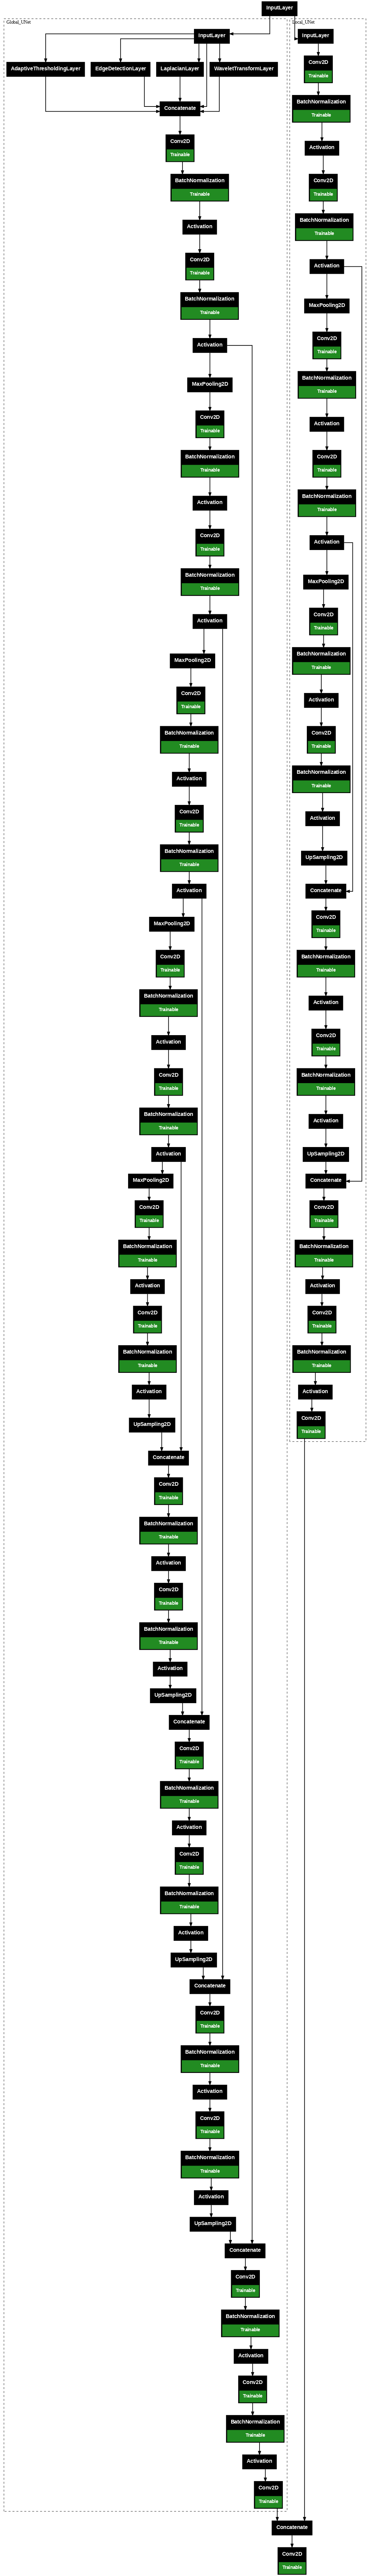

In [ ]:
# Create the dual-UNet model
model = get_dual_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [ ]:
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)
initial_learning_rate = 1e-3 # Peak learning rate
target_learning_rate = 1e-5  # Final learning rate
warmup_steps = 2000          # Number of warmup steps
decay_steps = 18000          # Total decay steps
alpha = target_learning_rate / initial_learning_rate  # Final lr as fraction of initial
lr_warmup_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
    warmup_steps=warmup_steps, alpha=alpha
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_warmup_decayed_fn, clipnorm=1.0)

In [ ]:
class DebugCallback(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        if logs['loss'] == float('nan'):
            print(f"NaN detected at batch {batch}")
            self.model.stop_training = True

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def class_limit_loss(y_true, y_pred):
    """
    Custom loss to penalize predictions that contain more than two classes per image.

    Args:
        y_true: Tensor of shape (Batch, 64, 128, 1) - ground truth labels.
        y_pred: Tensor of shape (Batch, 64, 128, 5) - predicted probabilities for each class.

    Returns:
        Scalar tensor representing the loss.
    """
    # Compute the average predicted probability for each class per image
    # Shape: (Batch, 5)
    avg_preds = tf.reduce_mean(y_pred, axis=[1, 2])

    # Extract the top two class probabilities for each image
    # Shape: (Batch, 2)
    top2 = tf.nn.top_k(avg_preds, k=2).values

    # Sum the top two probabilities
    # Shape: (Batch,)
    sum_top2 = tf.reduce_sum(top2, axis=-1)

    # Compute the penalty: how much the sum of top two is less than 1
    # Shape: (Batch,)
    penalty = 1.0 - sum_top2

    # Take the mean penalty over the batch
    loss = tf.reduce_mean(penalty)

    return loss

In [ ]:
# Custom Dice loss implementation
def dice_loss(y_true, y_pred, smooth=1e-6):
    # Flatten tensors to compute overlap
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    # Compute Dice coefficient
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_coeff = (2.0 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

    # Dice loss is 1 - Dice coefficient
    return 1.0 - dice_coeff

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # Convert y_true to one-hot encoding
    num_classes = y_pred.shape[-1]
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

    # Clip predictions to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0 - 1e-6)

    # Compute cross-entropy loss
    ce_loss = -y_true_one_hot * tf.math.log(y_pred)

    # Compute focal loss
    modulating_factor = tf.math.pow(1.0 - y_pred, gamma)
    focal_loss = alpha * modulating_factor * ce_loss

    # Reduce along the class dimension
    return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

import tensorflow as tf
from typing import List

def boundary_loss(probs: tf.Tensor, dist_maps: tf.Tensor, idc: List[int]) -> tf.Tensor:
    # Select the channels for the specified class indices `idc`
    pc = tf.gather(probs, idc, axis=1)  # Select the class indices along axis 1 (channels)
    dc = tf.gather(dist_maps, idc, axis=1)  # Select the same indices from the distance maps

    # Ensure the tensors are float32
    pc = tf.cast(pc, tf.float32)
    dc = tf.cast(dc, tf.float32)

    # Expand dist_maps to match the spatial dimensions of probs if needed
    dc = tf.expand_dims(dc, axis=-1)  # Add an extra dimension for broadcasting

    # Element-wise multiplication
    multiplied = pc * dc

    # Mean across all spatial dimensions and channels
    loss = tf.reduce_mean(multiplied)

    return loss

In [ ]:
@register_keras_serializable()
class DynamicWeightCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_weights):
        super().__init__()
        self.dice_weight, self.focal_weight, self.sparse_ce2_weight. self.boundary_weight = initial_weights

    def on_epoch_end(self, epoch, logs=None):
        # Adjust weights dynamically for all losses
        if logs['mean_iou'] < 0.5:  # If mean IoU is low, prioritize Dice Focal and Boundary loss
            self.boundary_weight += 0.05
            self.dice_weight += 0.05
            self.focal_weight += 0.05

        if logs['accuracy'] > 0.75:  # If accuracy is high, reduce Sparse CE importance
            # self.sparse_ce1_weight *= 0.9
            self.sparse_ce2_weight *= 0.9

        # if logs['loss'] > 2.5:  # If overall loss is high, prioritize focal and boundary loss
        #     self.focal_weight += 0.1
        #     self.boundary_weight += 0.1

        # Normalize weights to prevent explosion
        total_weight = self.dice_weight + self.focal_weight + self.sparse_ce1_weight + self.sparse_ce2_weight
        self.dice_weight /= total_weight
        self.focal_weight /= total_weight
        # self.sparse_ce1_weight /= total_weight
        self.sparse_ce2_weight /= total_weight
        self.boundary_weight /= total_weight

        # Print updated weights
        print(f"Updated Weights - Dice: {self.dice_weight:.3f}, Focal: {self.focal_weight:.3f}, Sparse CE2: {self.sparse_ce2_weight:.3f}, Boundary: {self.boundary_weight:.3f}")

        # Update the global weights
        dynamic_weights['dice_weight'] = self.dice_weight
        dynamic_weights['focal_weight'] = self.focal_weight
        # dynamic_weights['sparse_ce1_weight'] = self.sparse_ce1_weight
        dynamic_weights['sparse_ce2_weight'] = self.sparse_ce2_weight
        dynamic_weights['boundary_weight'] = self.boundary_weight

    def get_config(self):
        # Required for Keras serialization
        return {
            "initial_weights": [
                self.dice_weight,
                self.focal_weight,
                # self.sparse_ce1_weight,
                self.sparse_ce2_weight,
                self.boundary_weight,
            ]
        }

# Combined_loss function
def combined_loss(y_true, y_pred):
    global dynamic_weights
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)
    dice = dice_loss(y_true_one_hot, y_pred) * dynamic_weights['dice_weight']
    focal = focal_loss(y_true, y_pred) * dynamic_weights['focal_weight']
    # sparse_ce1 = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred) * dynamic_weights['sparse_ce1_weight']
    sparse_ce2 = tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=0)(y_true, y_pred) * dynamic_weights['sparse_ce2_weight']
    boundary = boundary_loss(y_pred,y_true,idc=[0, 1, 2, 3, 4]) * dynamic_weights['boundary_weight']
    class_limit = class_limit_loss(y_true, y_pred) * 1e-1
    return dice + focal + sparse_ce2 + class_limit + boundary

# Initialize global weights
dynamic_weights = {
    'dice_weight': 1.0,
    'focal_weight': 0.1,
    # 'sparse_ce1_weight': 0.2,
    'sparse_ce2_weight': 3.0,
    'boundary_weight': 0.1,
}

In [ ]:
# Dice metric
def dice_metric(y_true, y_pred):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
    return dice_loss(y_true_one_hot, y_pred)

# Focal loss metric
def focal_metric(y_true, y_pred):
    return focal_loss(y_true, y_pred)

# Sparse CE1 metric
# def sparse_ce1_metric(y_true, y_pred):
#     return tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)

# Sparse CE2 metric
def sparse_ce2_metric(y_true, y_pred):
    return tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=0)(y_true, y_pred)

# Boundary metric
def boundary_metric(y_true, y_pred):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
    return boundary_loss(y_pred,y_true,idc=[0, 1, 2, 3, 4])

In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=combined_loss,
    # optimizer=tf.keras.optimizers.AdamW(lr_warmup_decayed_fn,clipnorm=1.0),
    optimizer=optimizer,
        metrics=["accuracy", mean_iou, dice_metric, focal_metric, sparse_ce2_metric, boundary_metric]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    sample_weight=sample_weights_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    verbose=1
).history


Epoch 1/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 157s 993ms/step - accuracy: 0.4274 - boundary_metric: 0.2734 - dice_metric: 0.7342 - focal_metric: 0.2204 - loss: 4.8215 - mean_io_u: 0.2469 - sparse_ce2_metric: 1.3139 - val_accuracy: 0.2118 - val_boundary_metric: 0.2821 - val_dice_metric: 0.8047 - val_focal_metric: 0.3604 - val_loss: 6.0976 - val_mean_io_u: 0.0671 - val_sparse_ce2_metric: 1.7423
Epoch 2/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 309ms/step - accuracy: 0.5679 - boundary_metric: 0.2734 - dice_metric: 0.6468 - focal_metric: 0.1945 - loss: 3.6208 - mean_io_u: 0.4541 - sparse_ce2_metric: 0.9515 - val_accuracy: 0.2456 - val_boundary_metric: 0.2821 - val_dice_metric: 0.7376 - val_focal_metric: 0.3029 - val_loss: 5.3083 - val_mean_io_u: 0.1122 - val_sparse_ce2_metric: 1.4978
Epoch 3/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 308ms/step - accuracy: 0.5895 - boundary_metric: 0.2734 - dice_metric: 0.5984 - focal_metric: 0.1867 - loss: 3.1772 - mean_io_u: 0.4787 - sparse_ce2_metric: 0.8231 - val_accuracy: 0.3

In [ ]:
print(np.unique(y_train))  # Controlla se ci sono classi mancanti

[0. 1. 2. 3. 4.]


In [ ]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_'+str(sub_number)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 66.47%


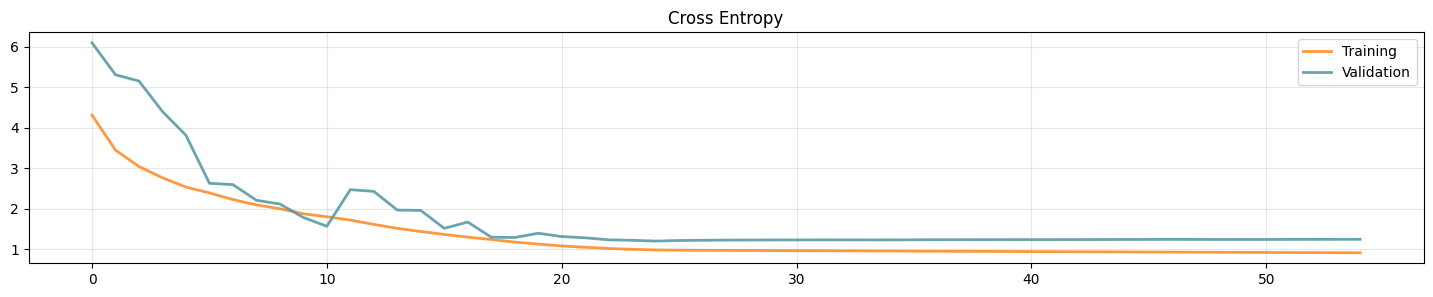

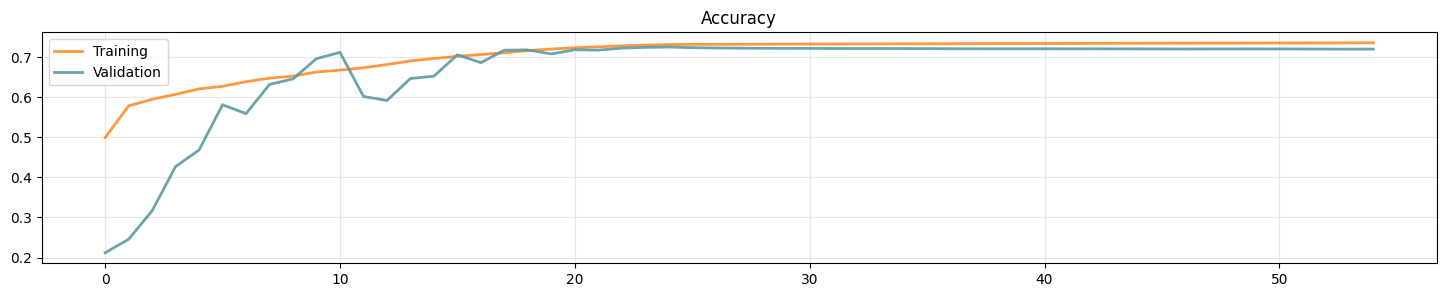

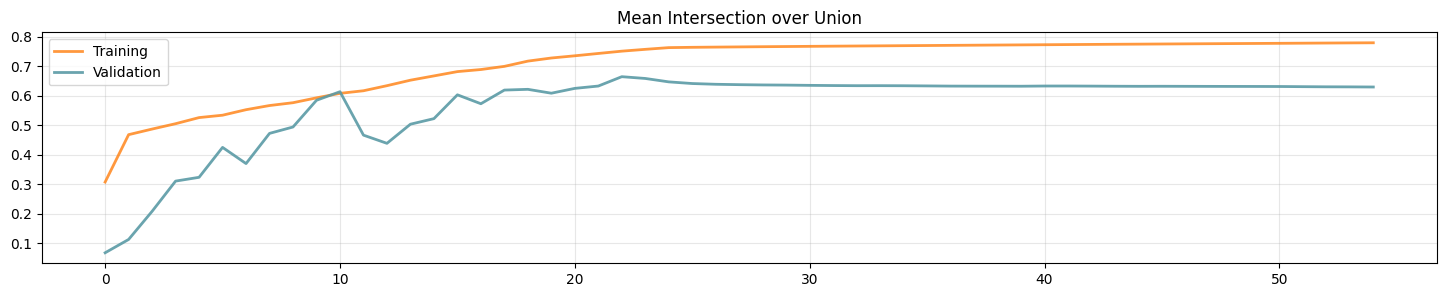

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Load UNet model without compiling
model = tfk.models.load_model('model_'+str(sub_number)+'.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", mean_iou]
)

In [ ]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(
    X_test, y_test, verbose=0, batch_size=10
)
print(f'Test Loss: {round(test_loss, 4)}')
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Loss: 1.2223
Test Accuracy: 0.6873
Test Mean Intersection over Union: 0.6208


In [ ]:
model_filename = f"model_after_test_{sub_number}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_after_test_40.1.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_after_test_40.1.keras


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 238 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
preds = model.predict(X_test_kaggle)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 56ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(submission_filename)

submission_after_test_40.1.csv
